In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import time

import numpy as np
from astropy import units as AstropyUnit
from astropy.time import Time as AstropyTime
from astropy.constants import Constant as AstropyConstant
from poliastro.bodies import Body as PoliastroBody
from poliastro.twobody import Orbit as PoliastroOrbit

import krpc
from krpc.client import Client
from typing import Union, NewType
Vessel = NewType("Vessel", object)
Body = NewType("Body", object)

from functools import reduce

conn = krpc.connect(name='jupyter')

def _convert_body_krpc_to_poliastro(poliastro_bodies: dict, parent: PoliastroBody, krpc_body: Body):
    name = krpc_body.name
    GM = AstropyConstant('GM_k{}'.format(name), 'Kerbal {} gravitational constant'.format(name),
                  krpc_body.gravitational_parameter, 'm3 / (s2)', 0,
                  'kRPC space_center.bodies["{}"].gravitational_parameter'.format(name), system='si')
    R = AstropyConstant('R_k{}'.format(name), 'Kerbal {} equatorial radius'.format(name),
                      krpc_body.equatorial_radius, 'm', 0,
                     'kRPC space_center.bodies["{}"].equatorial_radius'.format(name), system='si')
    poliastro_body = PoliastroBody(parent, GM, "", name, R)
    poliastro_bodies[name] = poliastro_body
    for satelite in krpc_body.satellites:
        _convert_body_krpc_to_poliastro(poliastro_bodies, poliastro_body, satelite)
    return

def krpc_poliastro_bodies(conn: Client) -> (dict, dict):
    poliastro_bodies = {}
    krpc_bodies = conn.space_center.bodies

    krpc_Sun = krpc_bodies["Sun"]
    _convert_body_krpc_to_poliastro(poliastro_bodies, None, krpc_Sun)
    return (krpc_bodies, poliastro_bodies)


krpc_bodies, poliastro_bodies = krpc_poliastro_bodies(conn)

In [2]:
krpc_ut = conn.space_center.ut
astropy_ut = AstropyTime(krpc_ut, format="unix")

vessel = conn.space_center.active_vessel
attractor = vessel.orbit.body
if conn.space_center.target_body:
    target = conn.space_center.target_body
    target_type = "CelestialBody"
elif conn.space_center.target_vessel:
    target = conn.space_center.target_vessel
    target_type = "Vessel"

reference_frame = krpc_bodies[attractor.name].non_rotating_reference_frame

r_target = target.position(reference_frame) * AstropyUnit.m
v_target = target.velocity(reference_frame) * AstropyUnit.m / AstropyUnit.s
ss_target = PoliastroOrbit.from_vectors(poliastro_bodies[attractor.name], r_target, v_target, epoch=astropy_ut)

r_i = vessel.position(reference_frame) * AstropyUnit.m
v_i = vessel.velocity(reference_frame) * AstropyUnit.m / AstropyUnit.s
ss_i = PoliastroOrbit.from_vectors(poliastro_bodies[attractor.name], r_i, v_i, epoch=astropy_ut)

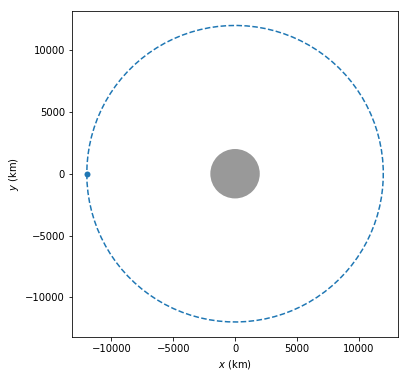

In [3]:
from poliastro.plotting import plot
plot(ss_target)

In [4]:
from poliastro.maneuver import Maneuver
ap_target = target.orbit.apoapsis
hoh = Maneuver.hohmann(ss_i, ap_target * AstropyUnit.m)
hoh.get_total_cost()

<Quantity 1.1880182385885187 km / s>

In [5]:
np.linalg.norm(hoh[0][1])

827.82306641025286

In [6]:
hoh.get_total_time().value

26814.322595008656

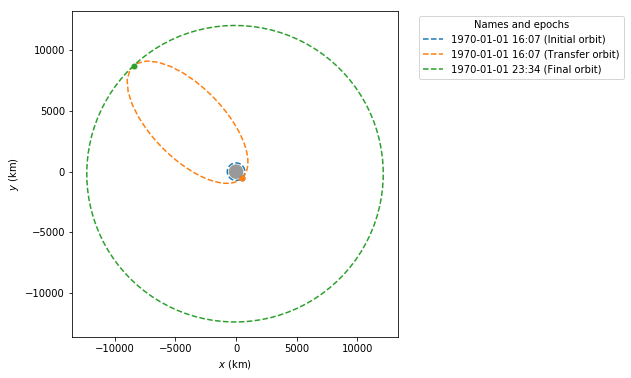

In [7]:
from poliastro.plotting import OrbitPlotter

op = OrbitPlotter()
ss_a, ss_f = ss_i.apply_maneuver(hoh, intermediate=True)
op.plot(ss_i, label="Initial orbit")
op.plot(ss_a, label="Transfer orbit")
op.plot(ss_f, label="Final orbit")

In [9]:
from poliastro.util import norm
delta_v = norm(tuple(val.decompose([AstropyUnit.m, AstropyUnit.s]) for val in hoh[0])[1])

In [10]:
ss_i.sample(1)

<CartesianRepresentation (x, y, z) in m
    [( 690623.59642449, -3245.16421246, -202804.18326979)]>

In [11]:
ss_a.propagate(hoh.get_total_time()).sample(1)

<CartesianRepresentation (x, y, z) in km
    [(-11638.07121987,  54.77171479,  3487.18237509)]>

In [23]:
ss_target.propagate(hoh.get_total_time()).sample()

<CartesianRepresentation (x, y, z) in km
    [(  8803.6141924 ,  0.,  -8154.53096471),
     (  9303.08196699,  0.,  -7579.75354763),
     (  9765.08951585,  0.,  -6974.4551397 ),
     ( 10187.77649769,  0.,  -6341.07306374),
     ( 10569.44090122,  0.,  -5682.15772559),
     ( 10908.54589858,  0.,  -5000.36234451),
     ( 11203.72603359,  0.,  -4298.43226964),
     ( 11453.79271994,  0.,  -3579.19392542),
     ( 11657.73902725,  0.,  -2845.54343062),
     ( 11814.74373558,  0.,  -2100.43493662),
     ( 11924.17464225,  0.,  -1346.86873219),
     ( 11985.59110692,  0.,   -587.87916209),
     ( 11998.74582849,  0.,    173.47759007),
     ( 11963.58583582,  0.,    934.1358101 ),
     ( 11880.25270607,  0.,   1691.03259568),
     ( 11749.08199212,  0.,   2441.12019067),
     ( 11570.6018719 ,  0.,   3181.37825706),
     ( 11345.53102162,  0.,   3908.82603691),
     ( 11074.77572193,  0.,   4620.53435469),
     ( 10759.42620863,  0.,   5313.63741216),
     ( 10400.75228269,  0.,   5985.3443

In [13]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def dot(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [14]:
angle_between(ss_a.propagate(hoh.get_total_time()).sample(1).xyz.value.take([0,1,2]),
              ss_target.propagate(hoh.get_total_time()).sample(1).xyz.value.take([0,1,2]))

2.6855533014518165

In [16]:
def hohmann_transfer_to_target_at_ut(vessel: Vessel, target: Union[Vessel, Body], ct: float, ut: float, trans_time: float = 0) -> ((float, float), float, float):
    attractor = vessel.orbit.body
    reference_frame = attractor.non_rotating_reference_frame

    krpc_ut = ut
    krpc_ct = conn.space_center.ut
    astropy_ct = AstropyTime(krpc_ct, format="unix")
    krpc_time_to_ut = krpc_ut - krpc_ct
    astropy_time_to_ut = krpc_time_to_ut * AstropyUnit.s
    
    r_target = target.position(reference_frame) * AstropyUnit.m
    v_target = target.velocity(reference_frame) * AstropyUnit.m / AstropyUnit.s
    ss_target = PoliastroOrbit.from_vectors(poliastro_bodies[attractor.name], r_target, v_target, epoch=astropy_ct)

    r_v_ct = vessel.position(reference_frame) * AstropyUnit.m
    v_v_ct = vessel.velocity(reference_frame) * AstropyUnit.m / AstropyUnit.s
    ss_v_ct = PoliastroOrbit.from_vectors(poliastro_bodies[attractor.name], r_i, v_i, epoch=astropy_ct)

    ss_i = ss_v_ct.propagate(astropy_time_to_ut)
    r_f = target.orbit.radius_at(krpc_ut + trans_time) * AstropyUnit.m

    hoh = Maneuver.hohmann(ss_i, r_f)
    
    trans_time = hoh.get_total_time().value
    ss_a, ss_f = ss_i.apply_maneuver(hoh, intermediate=True)
    
    dv_a = np.linalg.norm(hoh[0][1])
    dv_b = np.linalg.norm(hoh[1][1])
    
    phase_angle = angle_between(
        ss_a.propagate(hoh.get_total_time()).sample(1).xyz.value.take([0,1,2]),
        ss_target.propagate(hoh.get_total_time()).sample(1).xyz.value.take([0,1,2])
    )
    
    return (dv_a, dv_b, trans_time, phase_angle)

In [24]:
1 * AstropyUnit.s

<Quantity 1.0 s>